# Data Exploration
The Data Cleansing notebook gave a cleaner version of our NYC Apartments data that we can now use to perform some data exploration. This notebook will explore relationships between predictors and the response (price), as well as between other predictors. This will aid us later when building our model to predict the price of an apartment.

Note: This data comes from an AWS Lambda Pipeline that can be seen in [this GitHub Repo](https://github.com/scochran3/LazyApartment/tree/master/data_pipeline/lambda_functions)

## Libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
import numpy as np
import warnings

# Set the stage
warnings.filterwarnings('ignore')
output_notebook()
plt.rcParams['figure.figsize'] = (12.0, 8.0)

Loading BokehJS ...

## Read in the data

In [19]:
df = pd.read_csv('housing_cleaned.csv', index_col='id').drop('Unnamed: 0', axis=1)
df.describe()

area      bedrooms     bikeScore  distanceToNearestIntersection  \
count  3006.000000  11750.000000  12834.000000                   12772.000000   
mean    950.395542      2.147149     77.288297                      43.594549   
std     391.749448      0.958079     14.801187                      90.487586   
min       1.000000      1.000000      6.000000                       0.000000   
25%     725.000000      1.000000     68.000000                       0.122780   
50%     875.000000      2.000000     81.000000                      22.314235   
75%    1100.000000      3.000000     89.000000                      66.913226   
max    6037.000000      6.000000    117.000000                    5303.875176   

          has_image  has_map         price     repost_of  transitScore  \
count  12836.000000  12836.0  12836.000000  4.198000e+03   5468.000000   
mean       0.925444      1.0   2827.795419  6.499601e+09     95.853146   
std        0.262684      0.0   1178.785251  7.879162e+08     10.001638   
min        0.000000      1.0      0.000000  8.400758e+08     28.000000   
25%        1.000000      1.0   2150.000000  6.599528e+09     97.000000   
50%        1.000000      1.0   2600.000000  6.855166e+09    100.000000   
75%        1.000000      1.0   3299.000000  6.897376e+09    100.000000   
max        1.000000      1.0  12500.000000  6.920635e+09    100.000000   

          walkScore        ...             year    month           dow  \
count  12834.000000        ...          12836.0  12836.0  12836.000000   
mean      90.892084        ...           2019.0      6.0      2.306014   
std       15.249512        ...              0.0      0.0      2.257964   
min        0.000000        ...           2019.0      6.0      0.000000   
25%       91.000000        ...           2019.0      6.0      0.000000   
50%       96.000000        ...           2019.0      6.0      1.000000   
75%       98.000000        ...           2019.0      6.0      5.000000   
max      100.000000        ...           2019.0      6.0      6.000000   

                day          hour  bedrooms_filled  advertises_no_fee  \
count  12836.000000  12836.000000     12476.000000       12836.000000   
mean      23.796899     11.294328         2.059634           0.211359   
std        1.428725      7.884509         1.023242           0.408288   
min       21.000000      0.000000         0.000000           0.000000   
25%       23.000000      3.000000         1.000000           0.000000   
50%       24.000000     13.000000         2.000000           0.000000   
75%       25.000000     18.000000         3.000000           0.000000   
max       26.000000     23.000000         6.000000           1.000000   

          is_repost  sideOfStreetEncoded  postalCodeChopped  
count  12836.000000         12836.000000       12831.000000  
mean       0.327049             0.469149       10571.879588  
std        0.469154             0.499067        1325.260931  
min        0.000000             0.000000        6401.000000  
25%        0.000000             0.000000       10029.000000  
50%        0.000000             0.000000       11207.000000  
75%        1.000000             1.000000       11225.000000  
max        1.000000             1.000000       60154.000000  

[8 rows x 23 columns]

In [34]:
df.shape

(12836, 30)

## Assess the amount of NULL data points
This data is from from perfectly clean, we are scraping from Craigslist after all. The data pipeline is Craigslist Apartment Data -> Enrich with Mapquest Data -> Enrich with Walk Score data, so we tend to have a lot of missing data points. Let's quantify this.

In [20]:
# Create a DF with the count of nulls and the second column of percentage of df
nulls = pd.concat([df.isnull().sum(axis = 0), df.isnull().sum(axis = 0)/len(df)], axis=1)
nulls.columns = ['Number of Nulls', '% Null']
nulls

Number of Nulls    % Null
address                                      0  0.000000
area                                      9830  0.765815
bedrooms                                  1086  0.084606
bikeScore                                    2  0.000156
datetime                                     0  0.000000
distanceToNearestIntersection               64  0.004986
has_image                                    0  0.000000
has_map                                      0  0.000000
name                                         0  0.000000
postalCode                                   5  0.000390
price                                        0  0.000000
repost_of                                 8638  0.672951
sideOfStreet                                 0  0.000000
transitScore                              7368  0.574011
url                                          0  0.000000
walkScore                                    2  0.000156
where                                      839  0.065363
lat                                          0  0.000000
lon                                          0  0.000000
includes_area                                0  0.000000
year                                         0  0.000000
month                                        0  0.000000
dow                                          0  0.000000
day                                          0  0.000000
hour                                         0  0.000000
bedrooms_filled                            360  0.028046
advertises_no_fee                            0  0.000000
is_repost                                    0  0.000000
sideOfStreetEncoded                          0  0.000000
postalCodeChopped                            5  0.000390

Because we have many null features in some features such as area we are unlikely to use these. However, we were able to make features from these features such as "includes_area" which states whether the post includes area. For now we will drop scores if they have over 10% missing values.

## Drop features with missing values

In [21]:
# threshold = .1
# df.dropna(thresh=(1-threshold)*len(df), axis=1, inplace=True)

## Correlations

In [22]:
# Shrunk DF with only features we will plot
df_shrunk = df[['bikeScore', 'distanceToNearestIntersection', 'has_image', 'sideOfStreetEncoded', 
                'walkScore', 'where', 'includes_area', 'dow', 'day', 'hour', 'bedrooms_filled',
               'advertises_no_fee', 'is_repost', 'postalCodeChopped', 'price']]
df_shrunk['bikeScore'].fillna(df_shrunk['bikeScore'].mean(), inplace=True)

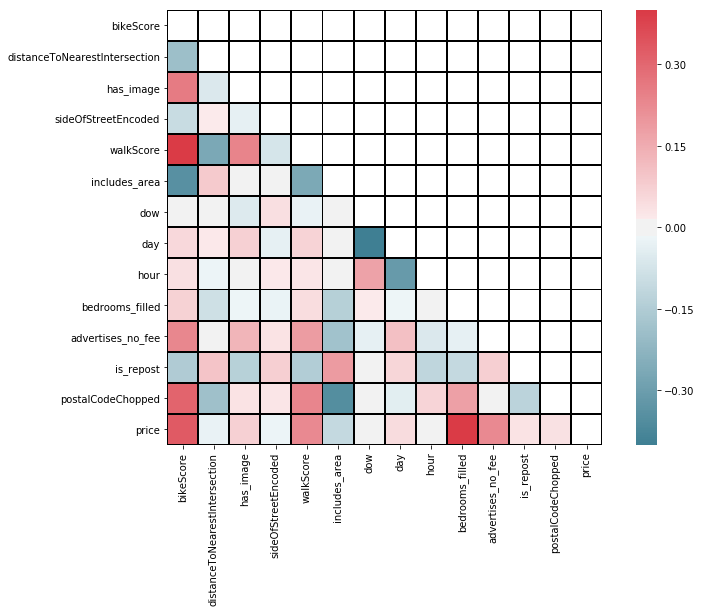

In [23]:
correlations = df_shrunk.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlations, mask=mask,
            cmap=cmap, linewidths=1, linecolor='#000000',
           square=True, vmax=.4, vmin=-.4)

## Univariate analysis

### Histogram of prices

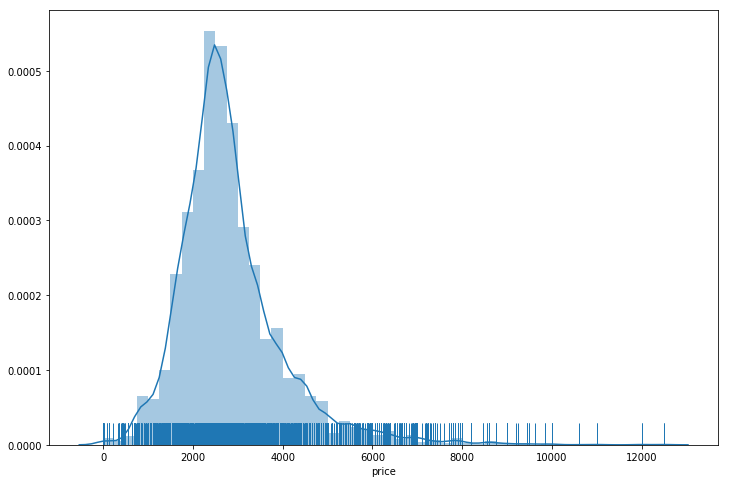

In [24]:
sns.distplot(df['price'], rug=True)

### Price by number of bedrooms

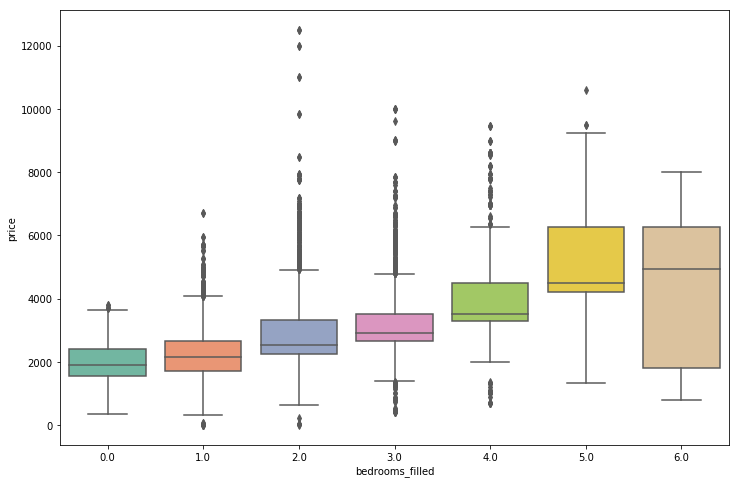

In [25]:
ax = sns.boxplot(x='bedrooms_filled', y='price', data=df, palette="Set2")

### Price by has_image

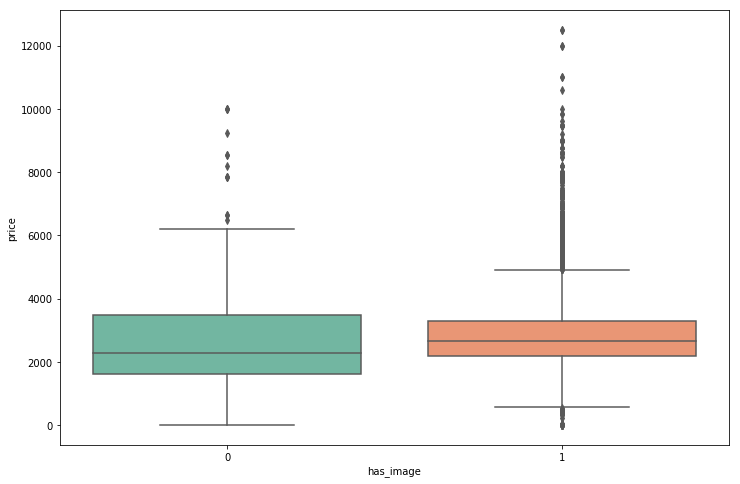

In [26]:
ax = sns.boxplot(x='has_image', y='price', data=df, palette="Set2")

### Price by neighborhood

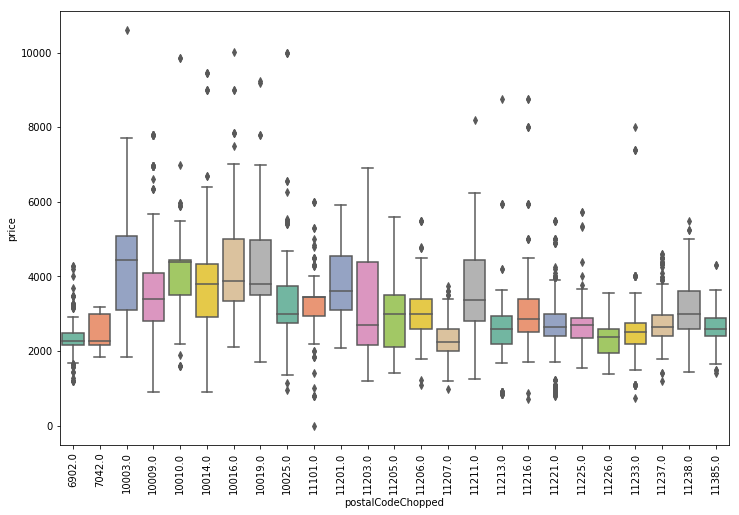

In [27]:
# Limit to top 25 neighborhoods by apartment count
df_top_25_hoods = df[df['postalCodeChopped'].isin(df['postalCodeChopped'].value_counts().head(25).index)]
df_top_25_hoods['postalCodeChopped'].value_counts()
plt.xticks(rotation=90)
ax = sns.boxplot(x='postalCodeChopped', y='price', data=df_top_25_hoods, palette="Set2")

### Price for whether or not they advertise "No Fee"

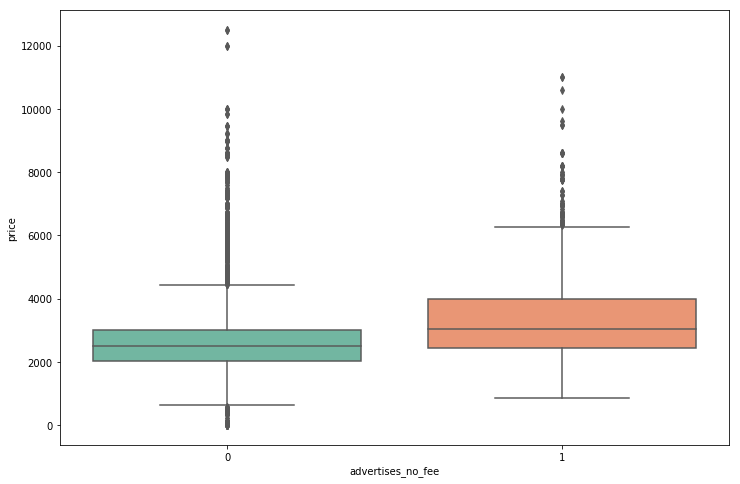

In [28]:
ax = sns.boxplot(x='advertises_no_fee', y='price', data=df, palette="Set2")

### Square Footage
I always read about how tiny New York City apartments are - let's see what the data tells us. Here we will overlay four different distributions - overall, 1 bedrooms, 2 bedrooms and 3 bedrooms.

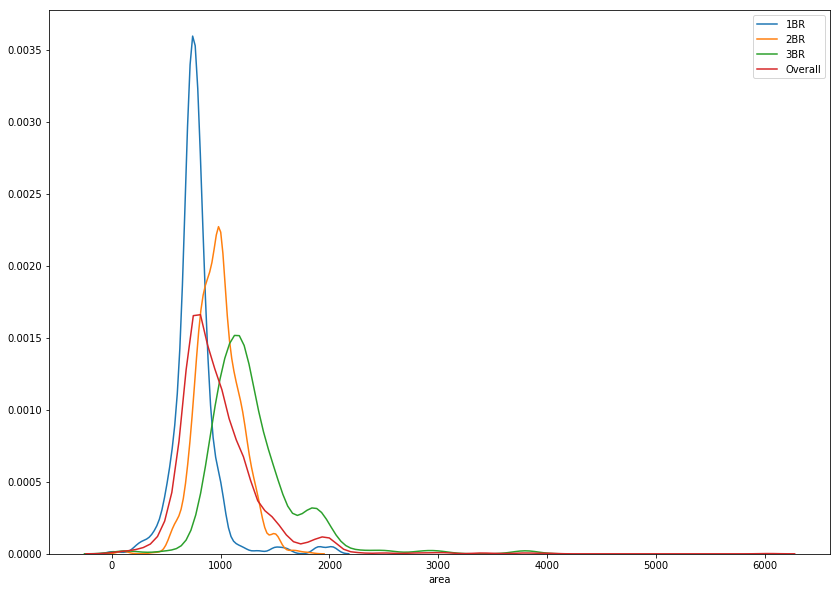

In [29]:
df_has_area = df.dropna(subset=['area', 'bedrooms'], axis=0)
fig, ax = plt.subplots(figsize=(14, 10))
sns.distplot(df_has_area[df_has_area['bedrooms']==1]['area'], label='1BR', hist=False)
sns.distplot(df_has_area[df_has_area['bedrooms']==2]['area'], label='2BR', hist=False)
sns.distplot(df_has_area[df_has_area['bedrooms']==3]['area'], label='3BR', hist=False)
sns.distplot(df_has_area['area'], label='Overall', hist=False)
ax.legend()

## Bivariate Analysis

### Area vs. Price
We have limited apartments that actually list the area but let's see how square footage increases with increasing the number of bedrooms

In [30]:
# Create string field for our color mapper
df_has_area['bedrooms_string'] = df_has_area['bedrooms'].astype(str) + " Bedrooms"
cmap = factor_cmap('bedrooms_string', palette=Spectral6, factors=df_has_area['bedrooms_string'].unique())

# Create figure
source = ColumnDataSource(df_has_area)
p = figure(sizing_mode='stretch_width', title="SQFT vs. Price", tools=[], toolbar_location=None)
p.scatter(x='area', y='price', source=source, legend='bedrooms_string',
          size=15, alpha=.6, fill_color=cmap, line_color='#000000', line_width=2)
p.legend.location = 'bottom_right'
p.xaxis.axis_label = "Square Feet"
p.yaxis.axis_label = "Price ($)"
p.y_range = Range1d(0, df_has_area['price'].max()*1.05)
show(p)

### Walk Score vs. Bike Score
Many algorithms will later not play nice with features that are perfectly correlated. While both features may be interesting to an individual it may be best to either only use one or a combination of the two in our model.

In [31]:
# Create figure
source = ColumnDataSource(df)
p = figure(sizing_mode='stretch_width', title="Walk Score vs. Bike Score", tools=[], toolbar_location=None)
p.scatter(x='walkScore', y='bikeScore', source=source)
p.xaxis.axis_label = "Walk Score (/100)"
p.yaxis.axis_label = "Bike Score (/100)"
# p.y_range = Range1d(0, df_has_area['price'].max()*1.05)
show(p)

## Price Over Time
Let's look at how prices vary over time for NYC Apartments

In [32]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df_price_per_day = df.set_index('datetime')[['price']]
df_price_per_day = df_price_per_day.resample('d').median().reset_index()

In [33]:
# Create the plot
source = ColumnDataSource(df_price_per_day)
p = figure(title="NYC Apartment Median Price Over Time", sizing_mode='stretch_width', x_axis_type='datetime')
p.line(x='datetime', y='price', line_width=2, color='#2e485c', source=source)
p.y_range = Range1d(0, df_price_per_day['price'].max()*1.05)
show(p)